# 12. 트랜스포머로 만드는 대화형 챗봇


## 데이터 수집

송영숙님이 공개한 [데이터](https://github.com/songys/Chatbot_data)를 훈련에 사용합니다.

In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


data = pd.read_csv(
    os.getenv("HOME") + "/aiffel/transformer_chatbot/data/ChatbotData .csv"
)
print(len(data))
data.head()

11823


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


데이터는 질문 `Q`와 답변 `A`로 이루어져 있습니다. `label`은 대화의 주제가 0(일상), 1(부정), 2(긍정)임을 나타내며 여기서는 사용하지 않습니다.

결측치 유무를 확인합니다.

In [2]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

결측치는 존재하지 않습니다.

## 데이터 전처리

데이터 전처리를 진행합니다.
1. 영문을 위한 소문자 변환 및 공백 제거
2. 문장 부호를 기준으로 부호 앞 공백 추가
3. 2개 이상의 공백을 하나의 공백으로 치환
4. 한글와 영문, 일부 문장 부호를 제외한 모든 문자 공백으로 처리

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

질문 문장에 전처리를 적용한 결과를 확인합니다.

In [4]:
for i in data["Q"].iloc[:5]:
    print(i, "->", preprocess_sentence(i))

12시 땡! -> 시 땡 !
1지망 학교 떨어졌어 -> 지망 학교 떨어졌어
3박4일 놀러가고 싶다 -> 박 일 놀러가고 싶다
3박4일 정도 놀러가고 싶다 -> 박 일 정도 놀러가고 싶다
PPL 심하네 -> ppl 심하네


전처리를 질문과 답변 데이터에 적용합니다.

In [5]:
questions = data["Q"].apply(preprocess_sentence)
answers = data["A"].apply(preprocess_sentence)
print("전체 샘플 수 :", len(questions))
print("전체 샘플 수 :", len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [6]:
for i in range(5):
    print(f"전처리 후의 {i+1}번째 질문 샘플: {questions[i]}")
    print(f"전처리 후의 {i+1}번째 답변 샘플: {answers[i]}")
    print()

전처리 후의 1번째 질문 샘플: 시 땡 !
전처리 후의 1번째 답변 샘플: 하루가 또 가네요 .

전처리 후의 2번째 질문 샘플: 지망 학교 떨어졌어
전처리 후의 2번째 답변 샘플: 위로해 드립니다 .

전처리 후의 3번째 질문 샘플: 박 일 놀러가고 싶다
전처리 후의 3번째 답변 샘플: 여행은 언제나 좋죠 .

전처리 후의 4번째 질문 샘플: 박 일 정도 놀러가고 싶다
전처리 후의 4번째 답변 샘플: 여행은 언제나 좋죠 .

전처리 후의 5번째 질문 샘플: ppl 심하네
전처리 후의 5번째 답변 샘플: 눈살이 찌푸려지죠 .



## SubwordTextEncoder 사용

텐서플로우에서 제공하는 [SubwordTextEncoder](https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder)를 사용합니다.

In [7]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2 ** 13
)

시작 토큰과 종료 토큰을 위한 인덱스를 설정합니다.

In [8]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print("START_TOKEN의 번호 :", [tokenizer.vocab_size])
print("END_TOKEN의 번호 :", [tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8325]
END_TOKEN의 번호 : [8326]


시작 토큰과 종료 토큰을 포함한 단어장의 크기를 설정합니다.

In [9]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8327


In [10]:
for i in range(5):
    print(f"정수 인코딩 후의 {i+1}번째 질문 샘플: {tokenizer.encode(questions[i])}")
    print(f"정수 인코딩 후의 {i+1}번째 답변 샘플: {tokenizer.encode(answers[i])}")
    print()

정수 인코딩 후의 1번째 질문 샘플: [1534, 3049, 37]
정수 인코딩 후의 1번째 답변 샘플: [3839, 72, 8057, 1]

정수 인코딩 후의 2번째 질문 샘플: [51, 915, 8101, 988, 1713]
정수 인코딩 후의 2번째 답변 샘플: [1830, 5523, 1]

정수 인코딩 후의 3번째 질문 샘플: [2998, 85, 3644, 76]
정수 인코딩 후의 3번째 답변 샘플: [3387, 772, 128, 1]

정수 인코딩 후의 4번째 질문 샘플: [2998, 85, 1386, 3644, 76]
정수 인코딩 후의 4번째 답변 샘플: [3387, 772, 128, 1]

정수 인코딩 후의 5번째 질문 샘플: [8181, 8181, 8177, 8101, 4188]
정수 인코딩 후의 5번째 답변 샘플: [977, 2293, 1484, 2177, 5489, 46, 1]



앞서 생성한 토크나이저를 사용하여 질문 문장과 답변 문장을 encoding합니다.

In [11]:
questions_tok = questions.apply(tokenizer.encode)
answers_tok = answers.apply(tokenizer.encode)

토큰 길이의 통계를 사용하여 토큰의 최대 길이를 설정합니다.

In [12]:
question_len = [len(q) for q in questions_tok]
answer_len = [len(a) for a in answers_tok]

print(
    f"질문 길이 최소 - 평균 - 최대: {np.min(question_len)} - {np.mean(question_len):.3f} - {np.max(question_len)}"
)
print(f"질문 길이 표준편차: {np.std(question_len):.3f}")
print(
    f"답변 길이 최소 - 평균 - 최대: {np.min(answer_len)} - {np.mean(answer_len):.3f} - {np.max(answer_len)}"
)
print(f"답변 길이 표준편차: {np.std(answer_len):.3f}")

q_six_sig = np.mean(question_len) + 3 * np.std(question_len)
a_six_sig = np.mean(answer_len) + 3 * np.std(answer_len)

MAX_LENGTH = int(max(q_six_sig, a_six_sig))
print("MAX_LENGTH:", MAX_LENGTH)

질문 길이 최소 - 평균 - 최대: 1 - 5.459 - 21
질문 길이 표준편차: 2.495
답변 길이 최소 - 평균 - 최대: 1 - 5.825 - 29
답변 길이 표준편차: 2.601
MAX_LENGTH: 13


앞선 과정에서 설정한 토큰의 최대 길이보다 짧은 문장이 전체 데이터에서 차지하는 비율을 확인합니다.

In [13]:
question_len = np.array(question_len)
maxlen_ratio_q = np.sum(question_len < MAX_LENGTH) / len(question_len) * 100
answer_len = np.array(answer_len)
maxlen_ratio_a = np.sum(answer_len < MAX_LENGTH) / len(answer_len) * 100

print("MAX_LENGTH:", MAX_LENGTH)
print(f"질문 문장의 {maxlen_ratio_q:.3f}%가 MAX_LENGTH 이내에 포함됩니다.")
print(f"답변 문장의 {maxlen_ratio_a:.3f}%가 MAX_LENGTH 이내에 포함됩니다.")

MAX_LENGTH: 13
질문 문장의 98.655%가 MAX_LENGTH 이내에 포함됩니다.
답변 문장의 97.742%가 MAX_LENGTH 이내에 포함됩니다.


토큰화가 완료된 결과의 앞과 뒤에 시작 토큰과 종료 토큰을 부여하고 최대 길이를 제한합니다.  
문장의 최대 길이를 기준으로 패딩을 진행합니다.

In [14]:
def wrap_and_pad(inputs, outputs):
    wrapped_input, wrapped_output = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + sentence1 + END_TOKEN
        sentence2 = START_TOKEN + sentence2 + END_TOKEN

        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            wrapped_input.append(sentence1)
            wrapped_output.append(sentence2)

    padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        wrapped_input, maxlen=MAX_LENGTH, padding="post"
    )
    padded_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        wrapped_output, maxlen=MAX_LENGTH, padding="post"
    )

    return padded_inputs, padded_outputs

최대 길이를 제한한 이후의 데이터를 확인합니다.

In [15]:
questions, answers = wrap_and_pad(questions_tok, answers_tok)
print("단어장의 크기:", (VOCAB_SIZE))
print("필터링 후의 질문 샘플 개수:", len(questions))
print("필터링 후의 답변 샘플 개수:", len(answers))

단어장의 크기: 8327
필터링 후의 질문 샘플 개수: 11156
필터링 후의 답변 샘플 개수: 11156


Tensorflow의 Dataset을 이용하여 입력 파이프라인을 준비하면서, Teacher Forcing을 위한 디코더의 입력 및 타겟 데이터를 정의합니다.

In [16]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 모델 구성

### 포지셔널 인코딩

동일한 단어에 대해 동일한 임베딩 레이어를 거치면 위치에 무관하게 같은 값의 벡터를 얻습니다. 하지만 포지셔널 인코딩을 적용하면 같은 단어라도 위치에 따라 다른 벡터를 얻을 수 있습니다. 
- sine 연산과 cosine 연산에 사용할 각도는 위치에 따라 계산됩니다.
- 짝수에 해당하는 항목에는 sine 연산을 적용합니다.
- 홀수에 해당하는 항목에는 cosine 연산을 적용합니다.

In [17]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

### 어텐션

1. Query와 Key의 내적을 통해 유사도를 구합니다.
2. 유사도의 크기가 너무 커져 학습에 부정적인 영향을 미치지 않도록 scaling을 적용합니다. (2-1. 마스크가 존재한다면 적용합니다. softmax 함수에 영향을 미치지 않을 정도로 아주 작은 값을 입력합니다.)
3. Softmax를 적용합니다.
4. 3번의 결과를 Value와 곱하여 어텐션를 얻습니다.

In [18]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += mask * -1e9

    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)
    return output

### Multi-Head Attention

Multi-Head Attention은 여러 헤드가 각각 어텐션 연산을 수행하는 과정입니다. 여러 관점에서 처리한 정보를 얻을 수 있습니다.
1. Query, Key, Value에 대해 unit이 d_model인 Dense 연산을 적용합니다.(d_model의 차원을 가진 벡터를 만들어냅니다.)
2. d_model의 크기를 가진 Query, Key, Value를 head 수에 맞추어 분할합니다.
3. 분할된 Query, Key, Value에 대해 어텐션 연산을 적용합니다.
4. 각각의 head에서 구한 어텐션을 concatenate합니다.
5. 연결된 어텐션에 Dense를 적용합니다.

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)
        return outputs

### 마스킹

문장의 길이를 맞추기 위해 사용한 `<PAD>` 정보를 사용하지 않도록 마스킹 연산을 정의합니다.
- `tf.cast`는 조건에 따라 1 또는 0 을 반환하는 함수입니다.
- 마스킹 정보가 존재하는 요소(`mask` 벡터에서 1로 존재)에는 아주 작은 음수가 입력되어 softmax에서 0에 가까운 값을 출력합니다.

In [20]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [21]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


함수를 테스트한 결과 0인 요소가 `mask` 벡터에서 1로 설정되어 있음을 확인할 수 있습니다.

### 인코더

하나의 인코더 층에는 2개의 서브 레이어가 존재합니다.

1. 셀프 어텐션(멀티-헤드 어텐션)
2. FFNN

- 각 레이어의 출력 결과에는 Dropout 또는 Layer Normalization을 적용합니다.

In [22]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

인코딩 층을 여러 개 쌓아 인코더를 구성합니다.

1. 입력 데이터에 마스킹을 적용합니다.
2. 임베딩 연산을 적용합니다.
3. 포지셔널 인코딩을 적용합니다.
4. Dropout을 적용합니다.
5. 여러 개의 인코딩 층을 통과합니다.

In [23]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더

트랜스포머는 입력 단어를 시점에 따라 순차적으로 입력받는 구조가 아니기 때문에 전체 문장을 한 번에 입력 받습니다. 이런 상황에서는 현재 단어보다 이후에 등장하는 미래의 단어 정보를 사용할 수 있기 때문에 이를 막을 수 있는 마스킹이 필요합니다.

In [24]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

Look-ahead mask 함수의 실행 결과를 테스트합니다.

In [25]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


현재 시점 이후의 데이터들에 대한 참조가 이루어지지 못하도록 마스크가 1로 설정되어 있습니다.

Look-ahead mask와 패딩을 위한 마스크가 동시에 잘 적용되는지 확인합니다.

In [26]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


현재 시점 이후의 데이터들에 대한 마스크와 첫번째 항목에 대한 패딩 마스크가 잘 적용되었음을 확인할 수 있습니다.

하나의 디코더 층에는 3개의 서브 레이어가 존재합니다.

1. 셀프 어텐션(멀티-헤드 어텐션)
2. 인코더-디코더 어텐션(멀티-헤드 어텐션)
    - 어텐션을 구하는 과정에서 Query는 디코더에서 얻은 정보를, Key와 Value는 인코더에서 얻은 정보를 사용합니다.
3. FFNN

- 각 레이어의 출력 결과에는 Dropout 또는 Layer Normalization을 적용합니다.

In [27]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )

    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )

    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(
        attention2 + attention1
    )

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

여러 개의 디코더 층을 쌓아 디코더를 구성합니다.

1. 입력 데이터에 마스킹을 적용합니다.
2. 임베딩 연산을 적용합니다.
3. 포지셔널 인코딩을 적용합니다.
4. Dropout을 적용합니다.
5. 여러 개의 디코딩 층을 통과합니다.

In [28]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

### 트랜스포머

1. 인코더와 디코더를 위한 각각의 입력을 설정합니다.
2. 인코더와 디코더를 위한 마스크를 설정합니다.
3. 인코더를 설정합니다.
4. 디코더를 설정합니다.
5. 다음 단어를 예측하는 출력 계층을 설정합니다.

In [29]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)

    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)

    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 모델 훈련

### 모델 생성

In [30]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3054336     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실 함수 정의

타켓 데이터에 패딩이 존재하기 때문에 손실을 계산하는 과정에 마스크를 적용합니다.

- 마스크가 적용되는 부분의 손실을 0으로 처리합니다.

In [31]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### Learning Rate Scheduling

Warmup_steps에 도달하기 전까지는 학습률을 선형적으로 증가시키다가, 도달한 이후에는 제곱근의 역수에 비례하여 감소시킵니다. 학습률은 아래의 수식을 따릅니다.

$$
lrate = d_{-0.5}^{model} \times min(step\_num^{-0.5}, step\_num \times warmup\_steps^{-1.5})
$$

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

200000 step 동안의 학습률 변화를 그래프를 통해 확인할 수 있습니다.

Text(0.5, 0, 'Train Step')

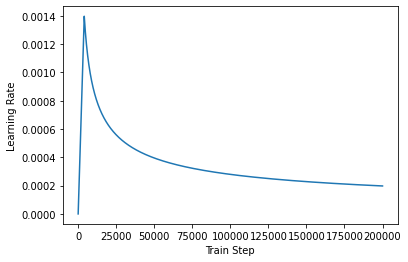

In [33]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

문장 시작 토큰이 출력되지 않아 `MAX_LENGTH - 1`의 크기를 기준으로 정확도를 측정합니다.

In [34]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

30 epoch 동안 훈련을 진행합니다.

In [35]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
175/175 [==============================] - 11s 30ms/step - loss: 4.5265 - accuracy: 0.0825
Epoch 2/30
175/175 [==============================] - 5s 30ms/step - loss: 3.6966 - accuracy: 0.1575
Epoch 3/30
175/175 [==============================] - 5s 30ms/step - loss: 3.1048 - accuracy: 0.1635
Epoch 4/30
175/175 [==============================] - 5s 30ms/step - loss: 2.8469 - accuracy: 0.1741
Epoch 5/30
175/175 [==============================] - 5s 30ms/step - loss: 2.6673 - accuracy: 0.1845
Epoch 6/30
175/175 [==============================] - 5s 30ms/step - loss: 2.4889 - accuracy: 0.1962
Epoch 7/30
175/175 [==============================] - 5s 30ms/step - loss: 2.2982 - accuracy: 0.2131
Epoch 8/30
175/175 [==============================] - 5s 30ms/step - loss: 2.0871 - accuracy: 0.2363
Epoch 9/30
175/175 [==============================] - 5s 30ms/step - loss: 1.8549 - accuracy: 0.2633
Epoch 10/30
175/175 [==============================] - 5s 30ms/step - loss: 1.6082 - accur

## 모델 평가

모델의 성능을 평가하기 위해 입력 문장에 대한 출력을 예측하는 과정을 함수로 정의합니다.

1. 훈련 데이터와 동일한 전처리 과정을 적용합니다.
2. 시작 토큰과 종료 토큰을 추가합니다.
3. 출력 문장이 계속해서 추가될 변수를 설정합니다.
4. 최대 문장 길이만큼 예측을 반복합니다.
    1. 모델이 입력 데이터를 이용하여 출력을 예측합니다.
    2. 예측 결과가 종료 토큰이라면 예측을 종료합니다.
    3. 예측 결과를 출력 문장이 담기는 변수에 추가합니다.
5. 최종적으로 완성된 문장을 return 합니다.

In [36]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

모델이 예측한 정수 토큰들을 텍스트로 변환합니다.

In [37]:
def sentence_generation(sentence):
    pred = decoder_inference(sentence)

    pred_sentence = tokenizer.decode([i for i in pred if i < tokenizer.vocab_size])

    print("입력:", sentence)
    print("출력:", pred_sentence)

    return pred_sentence

### 성능 평가 지표

모델 테스트에 사용할 문장들을 준비합니다.
문장 생성에 있어 성능을 평가하는 주관적인 지표를 설정합니다.

1. 입력 문장에 대해 자연스러운 대답: 3점
2. 자연스러운 대답은 아니지만 긍정 또는 부정의 의미가 통하거나: 1점
3. 전혀 어울리지 않는 대답이거나 문장이 제대로 완성되지 않는 경우: 0점

10개의 문장에 대해 최대 30점을 달성할 수 있습니다.

In [38]:
test_input = [
    "반가워!",
    "오늘 날씨가 좋아!",
    "요즘 어때?",
    "맛점해!",
    "같이 밥 먹을래요?",
    "요즘 아침에 운동을 하고 있어.",
    "지금 치킨을 시켜도 될까?",
    "꿈을 꿨어요.",
    "꿈은 도망가지 않아",
    "커피 한잔 할래요?",
]

훈련이 완료된 모델에 테스트 문장들을 입력합니다.

In [39]:
for test in test_input:
    none = sentence_generation(test)
    print()

입력: 반가워!
출력: 반갑습니다 .

입력: 오늘 날씨가 좋아!
출력: 시원한 바람 쉬고 약먹기 !

입력: 요즘 어때?
출력: 괜찮은 사람이에요 .

입력: 맛점해!
출력: 조금씩 더 행복해 질거 같아요

입력: 같이 밥 먹을래요?
출력: 식초 넣고 빨래해보세요 .

입력: 요즘 아침에 운동을 하고 있어.
출력: 좋아진 이상 이성으로 다가가야죠 .

입력: 지금 치킨을 시켜도 될까?
출력: 괜한 기대는 버리세요 .

입력: 꿈을 꿨어요.
출력: 많이 생각했나봐요 .

입력: 꿈은 도망가지 않아
출력: 아름다운 이별은 존재하니까요 .

입력: 커피 한잔 할래요?
출력: 감사합니다 .



1. 3점 / 2. 1점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 0점 / 7. 3점 / 8. 1점 / 9. 0점 / 10. 1점
총점: 3 + 1 + 3 + 1 + 1 = 9점(/30점)

## 모델 탐색

훈련 과정에서 확인할 수 있는 정확도만을 지표로 모델의 성능을 파악하기 쉽지 않고, 자체 평가 지표를 통해 확인한 모델의 성능 역시 우수하지 못하기에 추가적인 모델 탐색을 진행합니다.

1. NUM_LAYERS: 2, 4, 6
2. D_MODEL: 256, 512

In [40]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model.fit(dataset, epochs=EPOCHS, verbose=1)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    6894080     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [41]:
for test in test_input:
    none = sentence_generation(test)
    print()

입력: 반가워!
출력: 저도 반가워요 .

입력: 오늘 날씨가 좋아!
출력: 집밖에 나가기가 힘들것 같아요 .

입력: 요즘 어때?
출력: 사랑에 나이는 중요하지 않다고 생각해요 .

입력: 맛점해!
출력: 축하합니다 !

입력: 같이 밥 먹을래요?
출력: 손수건 준비할게요 .

입력: 요즘 아침에 운동을 하고 있어.
출력: 그 누구도 많이 좋아했나봐요 .

입력: 지금 치킨을 시켜도 될까?
출력: 한 잔 하세요 .

입력: 꿈을 꿨어요.
출력: 꿈은 현실의 반대래요 .

입력: 꿈은 도망가지 않아
출력: 그래서 우리는 꿈을 꾸죠 .

입력: 커피 한잔 할래요?
출력: 한 잔 하기 좋은 날이네요 .



1. 3점 / 2. 1점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 0점 / 7. 1점 / 8. 3점 / 9. 1점 / 10. 3점

총점: 3 + 1 + 1 + 3 + 1 = 9점(/30점)

In [42]:
tf.keras.backend.clear_session()

NUM_LAYERS = 4
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model.fit(dataset, epochs=EPOCHS, verbose=1)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3976960     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [43]:
for test in test_input:
    none = sentence_generation(test)
    print()

입력: 반가워!
출력: 반갑습니다 .

입력: 오늘 날씨가 좋아!
출력: 축하해요 !

입력: 요즘 어때?
출력: 괜찮은 사람이에요 .

입력: 맛점해!
출력: 축하합니다

입력: 같이 밥 먹을래요?
출력: 마음에 준비하는방법이 있는지 검색해서 준비해 .

입력: 요즘 아침에 운동을 하고 있어.
출력: 뭐든 열심히 하는 사람은 좋아보여요 .

입력: 지금 치킨을 시켜도 될까?
출력: 찔러보는 상대 별로네요 .

입력: 꿈을 꿨어요.
출력: 어떤 꿈이었나요 .

입력: 꿈은 도망가지 않아
출력: 차근차근 이뤄보아요 .

입력: 커피 한잔 할래요?
출력: 좋은 카페인이 필요한 시간인가 봐요 .



1. 3점 / 2. 0점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 3점 / 7. 1점 / 8. 3점 / 9. 1점 / 10. 3점

총점: 3 + 3 + 1 + 3 + 1 = 11점(/30점)

In [44]:
tf.keras.backend.clear_session()

NUM_LAYERS = 4
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model.fit(dataset, epochs=EPOCHS, verbose=1)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    9524736     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [45]:
for test in test_input:
    none = sentence_generation(test)
    print()

입력: 반가워!
출력: 반갑습니다 .

입력: 오늘 날씨가 좋아!
출력: 그래도 힘들죠 .

입력: 요즘 어때?
출력: 직접 물어보세요 .

입력: 맛점해!
출력: 조금씩 조심하세요 .

입력: 같이 밥 먹을래요?
출력: 아무렇지도 않는 날이 올 거예요 .

입력: 요즘 아침에 운동을 하고 있어.
출력: 왜 그 시간에 연락을 했을까요 .

입력: 지금 치킨을 시켜도 될까?
출력: 생각보다 많을 것도 일도 많을 것 같아요 .

입력: 꿈을 꿨어요.
출력: 꿈은 현실의 반대래요 .

입력: 꿈은 도망가지 않아
출력: 그래서 우리는 꿈을 꾸죠 .

입력: 커피 한잔 할래요?
출력: 좋은 사회생활의 밑거름이 되길 바랍니다 .



1. 3점 / 2. 0점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 0점 / 7. 0점 / 8. 3점 / 9. 3점 / 10. 0점

총점: 3 + 3 + 3 = 9점(/30점)

In [46]:
tf.keras.backend.clear_session()

NUM_LAYERS = 8
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model.fit(dataset, epochs=EPOCHS, verbose=1)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    5822208     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [47]:
for test in test_input:
    none = sentence_generation(test)
    print()

입력: 반가워!
출력: 좋은 마무리하길 바라요 .

입력: 오늘 날씨가 좋아!
출력: 잘 볼 수 있을 거예요 .

입력: 요즘 어때?
출력: 그런 생각은 버리세요 .

입력: 맛점해!
출력: 돈을 얼른 모아야할 이유가 생겼네요 .

입력: 같이 밥 먹을래요?
출력: 이제 일어날 시간이에요 .

입력: 요즘 아침에 운동을 하고 있어.
출력: 많이 지쳤나봐요 .

입력: 지금 치킨을 시켜도 될까?
출력: 직접 주는 게 더 좋을 것 같아요 .

입력: 꿈을 꿨어요.
출력: 그런 사람 만나길 바랄게요 .

입력: 꿈은 도망가지 않아
출력: 이제 일어날 시간이에요 .

입력: 커피 한잔 할래요?
출력: 다른 곳에 쓰려고 운을 아껴뒀나봐요 .



1. 3점 / 2. 0점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 0점 / 7. 0점 / 8. 0점 / 9. 0점 / 10. 0점

총점: 3점(/30점)

In [48]:
tf.keras.backend.clear_session()

NUM_LAYERS = 8
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model.fit(dataset, epochs=EPOCHS, verbose=1)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    14786048    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [49]:
for test in test_input:
    none = sentence_generation(test)
    print()

입력: 반가워!
출력: 저도 데려가세요 .

입력: 오늘 날씨가 좋아!
출력: 네

입력: 요즘 어때?
출력: 혼자만 힘든 거 아니에요 .

입력: 맛점해!
출력: 지금보다 더 잘 살 거예요 .

입력: 같이 밥 먹을래요?
출력: 저한테 말해보세요 .

입력: 요즘 아침에 운동을 하고 있어.
출력: 힘들겠어요 .

입력: 지금 치킨을 시켜도 될까?
출력: 보통 다 압니다 .

입력: 꿈을 꿨어요.
출력: 내 집 마련한 걸음을 한 지겠네요 .

입력: 꿈은 도망가지 않아
출력: 너무 무리하지 마세요 .

입력: 커피 한잔 할래요?
출력: 저도 좋은 선물이 될 거예요 .



1. 0점 / 2. 1점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 3점 / 7. 0점 / 8. 0점 / 9. 0점 / 10. 0점

총점: 1 + 3 = 4점(/30점)

## 모델 탐색 결과

| NUM_LAYERS | D_MODEL | accuracy | 점수 |
| --- | --- | --- | --- |
| 2 | 256 | 53.45% | 9 |
| 2 | 512 | **53.61%** | 9 ||
| 4 | 256 | 52.45% | **11** |
| 4 | 512 | 52.96% | 9 |
| 6 | 256 | 33.85% | 3 |
| 6 | 512 | 35.60% | 4 |

- D_MODEL과 무관하게 NUM_LAYERS가 6인 모델의 정확도는 다른 설정에서의 모델보다 정확도가 많이 떨어졌고, 이에 따라 성능 평가에서도 낮은 점수를 보였습니다.
- 성능 평가를 위한 점수와 정확도가 어느 정도 비례한다는 것을 확인할 수 있었습니다.


## 추가 모델 탐색

앞선 모델 탐색 결과에서 정확도와 점수가 비례 관계에 있다는 것을 확인하고, 정확도를 올릴 수 있도록 추가적인 모델 탐색을 진행합니다.

- NUM_LAYERS가 4인 경우보다 2인 경우의 정확도가 미세하지만 높았기에, 더 낮은 숫자를 실험 설정에 포함시킵니다.
- D_MODEL이 256인 경우보다 512인 경우의 경확도가 높았기에, 더 큰 숫자를 실험 설정에 포함시킵니다.
- 이전 실험들은 모두 동일하게 30 epoch으로 진행하였지만, 훈련 종료 이후 loss가 1에 가까운 경우가 존재하였습니다. 학습이 충분히 진행되지 못한 상황이라 생각되어 epoch을 60으로 증가시켜 설정하였습니다.

1. NUM_LAYERS: 1, 2, 4
2. D_MODEL: 512, 1024
3. EPOCHS: 60

In [50]:
EPOCHS = 60

class EveryFiveEpoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{EPOCHS} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f}")
            
            
everyfive =  EveryFiveEpoch()           

In [51]:
tf.keras.backend.clear_session()

NUM_LAYERS = 1
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
hist = model.fit(dataset, epochs=EPOCHS, verbose=0, callbacks=[everyfive])

print()
print(f"loss: {hist.history['loss'][-1]:.4f} - accuracy: {hist.history['accuracy'][-1]:.4f}")
print()

for test in test_input:
    none = sentence_generation(test)
    print()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    5578752     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

1. 3점 / 2. 0점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 1점 / 7. 0점 / 8. 3점 / 9. 3점 / 10. 0점

총점: 3 + 1 + 3 + 3 = 10점(/30점)

In [52]:
tf.keras.backend.clear_session()

NUM_LAYERS = 1
D_MODEL = 1024
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
hist = model.fit(dataset, epochs=EPOCHS, verbose=0, callbacks=[everyfive])

print()
print(f"loss: {hist.history['loss'][-1]:.4f} - accuracy: {hist.history['accuracy'][-1]:.4f}")
print()

for test in test_input:
    none = sentence_generation(test)
    print()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 1024)   12729856    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

1. 3점 / 2. 0점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 1점 / 7. 1점 / 8. 3점 / 9. 3점 / 10. 0점

총점: 3 + 1 + 1 + 3 + 3 = 11점(/30점)

In [53]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
hist = model.fit(dataset, epochs=EPOCHS, verbose=0, callbacks=[everyfive])

print()
print(f"loss: {hist.history['loss'][-1]:.4f} - accuracy: {hist.history['accuracy'][-1]:.4f}")
print()

for test in test_input:
    none = sentence_generation(test)
    print()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    6894080     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

1. 3점 / 2. 1점 / 3. 1점 / 4. 3점 / 5. 0점 / 6. 1점 / 7. 0점 / 8. 3점 / 9. 3점 / 10. 0점

총점: 3 + 1 + 1 + 3 + 1 + 3 + 3 = 15점(/30점)

In [54]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2
D_MODEL = 1024
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
hist = model.fit(dataset, epochs=EPOCHS, verbose=0, callbacks=[everyfive])

print()
print(f"loss: {hist.history['loss'][-1]:.4f} - accuracy: {hist.history['accuracy'][-1]:.4f}")
print()

for test in test_input:
    none = sentence_generation(test)
    print()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 1024)   16932864    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

1. 3점 / 2. 0점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 0점 / 7. 0점 / 8. 3점 / 9. 3점 / 10. 0점

총점: 3 + 3 + 3 = 9점(/30점)

In [55]:
tf.keras.backend.clear_session()

NUM_LAYERS = 4
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
hist = model.fit(dataset, epochs=EPOCHS, verbose=0, callbacks=[everyfive])

print()
print(f"loss: {hist.history['loss'][-1]:.4f} - accuracy: {hist.history['accuracy'][-1]:.4f}")
print()

for test in test_input:
    none = sentence_generation(test)
    print()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    9524736     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

1. 3점 / 2. 0점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 0점 / 7. 0점 / 8. 3점 / 9. 3점 / 10. 0점

총점: 3 + 3 + 3 = 9점(/30점)

In [56]:
tf.keras.backend.clear_session()

NUM_LAYERS = 4
D_MODEL = 1024
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model.summary()
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
hist = model.fit(dataset, epochs=EPOCHS, verbose=0, callbacks=[everyfive])

print()
print(f"loss: {hist.history['loss'][-1]:.4f} - accuracy: {hist.history['accuracy'][-1]:.4f}")
print()

for test in test_input:
    none = sentence_generation(test)
    print()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 1024)   25338880    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

1. 3점 / 2. 0점 / 3. 0점 / 4. 0점 / 5. 0점 / 6. 1점 / 7. 0점 / 8. 3점 / 9. 3점 / 10. 0점

총점: 3 + 1 + 3 + 3 = 10점(/30점)

### 추가 모델 탐색 결과

| NUM_LAYERS | D_MODEL | accuracy | 점수 |
| --- | --- | --- | --- |
| 1 | 512 | **54.14%** | 10 |
| 1 | 1024 | 54.09% | 11 ||
| 2 | 512 | 54.10% | **15** |
| 2 | 1024 | 54.06% | 9 |
| 4 | 512 | 53.99% | 9 |
| 4 | 1024 | 53.96% | 10 |

- NUM_LAYERS를 2로, D_MODEL을 512로 설정한 모델은 정확도가 가장 높지는 않았지만 점수가 가장 높았습니다.

## 결론

```
입력: 반가워!
출력: 반갑습니다 .

입력: 오늘 날씨가 좋아!
출력: 집밖에 나가기가 힘들것 같아요 .

입력: 요즘 어때?
출력: 저도 듣고 싶어요 .

입력: 맛점해!
출력: 맛있는 거 드세요 .

입력: 같이 밥 먹을래요?
출력: 손수건 준비할게요 .

입력: 요즘 아침에 운동을 하고 있어.
출력: 고생했어요 .

입력: 지금 치킨을 시켜도 될까?
출력: 같이 살자고 프로포즈 해보세요 .

입력: 꿈을 꿨어요.
출력: 많이 생각했나봐요 .

입력: 꿈은 도망가지 않아
출력: 차근차근 이뤄보아요 .

입력: 커피 한잔 할래요?
출력: 커피는 셀프였으면 좋겠어요 .
```

- 테스트를 위해 준비한 모든 문장에 대해 적절한 답변을 예측하지는 못했지만, 일부 문장에 대해 좋은 답변을 예측하였으며 문장이 어색한 경우는 없었습니다.
- 성능 평가를 위해 주관적인 판단이 포함된 평가 기준을 만들어 모델을 평가하고 좋은 성능의 모델을 탐색할 수 있었습니다.
- 학습 데이터가 약 12,000개로 대량의 데이터는 아니었기에 데이터 부족으로 인한 성능의 한계도 예상할 수 있습니다.
- 성능 평가를 위해 주관적인 판단이 포함된 평가 기준을 만들었지만, 모델의 성능을 객관적으로 평가할 지표가 없다는 점에 대해서는 추가적인 고찰이 필요합니다.
    - 데이터를 1인이 수집하여 가공한 것으로 개인의 주관이 많이 들어가 있을 것으로 생각됩니다. 따라서 모델의 예측 경향이 데이터 수집 주체의 주관을 따라가는 경향이 있을 가능성이 높습니다. 
    - 성능 평가를 위해 설정한 점수 역시 본인의 주관이 많이 반영되어 있습니다.
    - 이러한 개개인의 주관이나 경향이 미치는 영향을 줄이기 위해서는 다양한 출처에서 획득한 대량의 데이터셋을 사용하고, 많은 사람들의 주관적인 성능 평가를 통해 객관성을 확보해야 합니다.

## 루브릭

|평가문항|상세기준|
|---|---|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.|

### 루브릭 자체평가

1. 공백과 문장 기호의 전처리, 토큰화의 과정을 수행하였다.
2. 트랜스포머 모델의 학습이 성공적으로 진행되었다.
3. 한국어 입력 문장에 적절한 답변을 예측하였다.